# Data Splitting and Modelling

Author: Gillian A. McGinnis, final-semester M.S. Information Science - Machine Learning  
The University of Arizona College of Information  
INFO 698 - Capstone  
Start date: 21 October 2025  
Last updated: 25 November 2025

In [1]:
"""
Module providing code for test/train split and sliding window creation. Relies on 01_clean.ipynb completion.
"""

'\nModule providing code for test/train split and sliding window creation. Relies on 01_clean.ipynb completion.\n'

## Setup

### Packages

In [2]:
# GPU Setup
%load_ext cudf.pandas
import pandas as pd
import cudf
import cupy as cp

import cuml.accel
cuml.accel.install()

# General packages
import numpy as np
import xgboost as xgb
from scipy.stats import randint, uniform
# For getting medians for windowing/smoothing
from scipy.signal import medfilt

# For saving models
import joblib
import pickle

from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV, TunedThresholdClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve, make_scorer, roc_auc_score, auc
# For help with model tuning
from sklearn.base import clone

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

from google.colab import userdata
import os

if os.getcwd() == '/content':
  gh_repo = userdata.get('gh_repo')
  if not os.path.exists(f'{gh_repo}'):
    print("Cloning repo...")
    gh_pat = userdata.get('gh_pat')
    gh_user = userdata.get('gh_user')
    repo_url = f'https://{gh_pat}@github.com/{gh_user}/{gh_repo}'
    !git clone {repo_url}
    del gh_pat, gh_user, repo_url
  print("Changing wd...")
  os.chdir(f'{gh_repo}/code')
  del gh_repo

# # Verify the current working directory
print(f"Current working directory is: {os.getcwd()}")


Cloning repo...
Cloning into 'info-698-capstone'...
remote: Enumerating objects: 502, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 502 (delta 122), reused 42 (delta 24), pack-reused 328 (from 1)
Receiving objects: 100% (502/502), 43.22 MiB | 17.73 MiB/s, done.
Resolving deltas: 100% (298/298), done.
Changing wd...
Current working directory is: /content/info-698-capstone/code


In [4]:
# For data importing and exporting
from helper_utils import get_path, model_path, apply_model, report_scores

In [5]:
# # To make it easier to tell when processes have completed -- can delete later
# Google colab compatible:
# https://stackoverflow.com/a/68582785/23486987
from IPython.display import Audio, display

def play_chime():
  return Audio(get_path('completed.mp3', 'code'), autoplay=True)

In [6]:
## (Optional chunk)
# Current session information

# From StackOverflow,
# https://stackoverflow.com/a/62128239/23486987
try:
    import session_info
except:
    !pip install session_info
    import session_info
# !pip install session_info
# import session_info
session_info.show(dependencies=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 7.9 MB/s eta 0:00:00


In [7]:
# Make sure GPU active
# !nvidia-smi
import torch
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Warning: GPU not found!")

Using GPU: NVIDIA A100-SXM4-40GB


## Inputs

### Constants

In [8]:
## Variable of interest
# for the model to predict
VAR_OF_INTEREST = "obstruction_ro"

## Date subsets
# (for testing smaller runs)
# Set to None to use all data
DATE_START = None
DATE_END = None
# DATE_START = '2001-02-01 00:00:00'
# DATE_END = '2011-12-31 23:59:59'

## Cutoff for correlation for feature removal
# (i.e., columns that are at least this correlated will be removed)
CORR_CUTOFF = 0.97

## Number of splits
# for hyperparameter tuning via expanding window
N_SPLITS = 5

## Number of rounds after which to stop the build
# once the performance stops improving
EARLY_STOPPING_ROUNDS = 50

# Define hyperparameter distributions for random search
# N_ESTIMATORS = 1000
N_ESTIMATORS = 100

## Number of times to iterate the tuning loop
# (set to a small number for testing)
N_ITERATIONS = 5
# N_ITERATIONS = 50


## Smoothing window sizes -- must be odd
# Smallest window size
WINDOW_MIN = 1
# Largest window size
# WINDOW_MAX = 35
WINDOW_MAX = 10

## Model names
MODEL_NAME = "mini_tests"
FITTED_MODEL_NAME = MODEL_NAME+"_fitted"

## Seed for reproducability
SEED = 42

In [9]:
# Set seed
np.random.seed(SEED)
cp.random.seed(SEED)

In [10]:
# ### Note ###
# # Set to None later -- just a smaller subset for feature engineering testing
# # DATE_START = '2000-01-01 00:00:00'
# DATE_START = '2001-02-01 00:00:00'
# DATE_END = '2011-12-31 23:59:59'
# DATE_START= None
# DATE_END = None
# ######

### Data

In [11]:
united_water = pd.read_parquet(get_path('clean/water_nocal.parquet'))
united_soil = pd.read_parquet(get_path('clean/soil.parquet'))

data_cal = pd.read_parquet(get_path('clean/calibration.parquet'))
data_cal = data_cal.rename(columns={'weir_level':'weir_level_cal'})

In [12]:
data_cal.info()

<class 'cudf.core.dataframe.DataFrame'>
DatetimeIndex: 6136 entries, 1994-01-03 08:46:00 to 2025-08-01 09:10:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   weir_level_cal  6136 non-null   int8
dtypes: int8(1)
memory usage: 53.9 KB


#### Memory improvements

Small amount of data wrangling for memory improvements (some as a consequence of importing).

In [13]:
# Select columns of interest
data_water = united_water.drop(columns=['raw_rain', 'chk_note_rain', 'chk_fail_rain', 'chk_note_ro', 'chk_fail_ro', 'comment_ro', 'source_ro'])

# Cleanup
del united_water

# Remove duplicate entries
data_water = data_water.reset_index().drop_duplicates(keep='first').set_index('datetime')

In [14]:
water_drops = ['level_ro', 'obstruction_ro', 'gap_fill_ro', 'weir_cleaning_ro', 'spike_ro', 'calibration_ro']
water_drops.remove(VAR_OF_INTEREST)

data_water = data_water.drop(water_drops, axis=1)

del water_drops

data_water.info(memory_usage="deep")

<class 'cudf.core.dataframe.DataFrame'>
DatetimeIndex: 3581782 entries, 1989-06-21 13:00:00 to 2025-08-01 13:00:00
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   ra_rain         float32
 1   raw_ro          float32
 2   obstruction_ro  bool
dtypes: bool(1), float32(2)
memory usage: 59.4 MB


In [15]:
united_soil['sample'] = united_soil['sample'].astype('category')

In [16]:
# Subset data (if applicable)
data_water = data_water[DATE_START:DATE_END]

## Feature Engineering

### Distance from Event

In [17]:
def timesince_feat(input_df, input_col, input_unit):
    output_df = input_df
    instances = output_df[input_col].notna()
    # Create groupings based on most recent instance
    group_id = instances.cumsum()
    # Exclude the first grouping
    # otherwise it assumes there was an event just prior to the first entry
    group_id = group_id.replace(0, np.nan)
    # Create new column to count the distance in days since the point
    # which resets to 0 at each new point
    output_df['timestamp'] = pd.to_datetime(output_df.index)
    # Get start timestamp of the group
    output_df['ts_start'] = output_df.groupby(group_id)['timestamp'].transform('min')
    # Calculate the distance
    if input_unit == "minutes":
        output_df[f"minsince_{input_col}"] = (output_df['timestamp'] - output_df['ts_start']).dt.total_seconds().div(60).astype(np.float32)
    elif input_unit == "days":
        output_df[f"daysince_{input_col}"] = (output_df['timestamp'] - output_df['ts_start']).dt.days.astype(np.float32)
    # Remove extra cols
    output_df = output_df.drop(columns=['timestamp', 'ts_start'])
    return output_df

#### Rain
Create feature which tracks how recent a rain event occurred.

In [18]:
data_water = timesince_feat(data_water, 'ra_rain', "minutes")

### Rain event

Keep track of cumulative rainfall during a specific event.

In [19]:
# Create index of instances where there is a data point
rain_event = (data_water['ra_rain'].isnull() & ((data_water['minsince_ra_rain'] >= 5.0) & (data_water['minsince_ra_rain'] != 0)))
# Create groupings based on most recent instance
rain_event_id = rain_event.cumsum()
# Create new column to count number of records since the point
# which resets to 0 at each new point
data_water['eventsum_ra_rain'] = data_water.groupby(rain_event_id)['ra_rain'].cumsum()

del rain_event, rain_event_id

### Decay

In [20]:
def decay_feat(input_df, input_col, input_dec_rate = -0.1):
    output_df = input_df
    if f"minsince_{input_col}" not in output_df.columns:
        output_df = timesince_feat(input_df = output_df, input_col = input_col, input_unit = "minutes")
    # Update for GPU for overflow fix
    output_df[f"minsince_{input_col}"] = output_df[f"minsince_{input_col}"].astype(np.float64)

    output_df[f"decayrate{input_dec_rate}_{input_col}"] = np.exp(input_dec_rate * output_df[f"minsince_{input_col}"]).astype(np.float32)
    output_df[f"ffill_{input_col}"] = output_df[input_col].ffill()
    output_df[f"decay{input_dec_rate}_{input_col}"] = (output_df[f"ffill_{input_col}"] * output_df[f"decayrate{input_dec_rate}_{input_col}"])

    return output_df

In [21]:
# Replace NAs in rain with 0
data_water['ra_rain'] = data_water['ra_rain'].fillna(0)

# Apply decay function
data_water = decay_feat(data_water, 'eventsum_ra_rain')

# Drop extra column
# minutes since rain event will be the same as minutes since most recent rain
data_water = data_water.drop('minsince_eventsum_ra_rain', axis=1)

### Lag features

Because XGBoost predicts on one data point at a time, time series data must include "lag" features (i.e., data points prior to that event) in order to better repsent recent history.

#### Consistent cols

Modify the rows to prevent inappropriate data shifts.
This expands the index to include _all_ possible 5 minute time stamps, so that lagging by index difference guarantees the temporal consistency of lagged features.
This is important because there are some gaps of data, and it would be incorrect for a features that measures "rainfall 5 minutes ago" was actually representing that of the immediately previous point a few hours (or, in some cases, _years_) back due to large data gaps.

In [22]:
original_indices = data_water.index.copy()

new_index = pd.date_range(start = data_water.index.min(),
                          end = data_water.index.max(),
                          freq = '5min')

# Reindex
data_water = data_water.reindex(new_index)

# Cleanup
del new_index

# # Return
# data_water = data_water.loc[original_indices]
# del original_indices

Get values from other recent time stamps.

In [23]:
def lag_feats(input_df, input_cols, input_lags):
    output_df = input_df#.copy()
    for col in input_cols:
        for lag in input_lags:
            output_df[f"{col}_lag{lag}"] = output_df[col].shift(lag)
    return output_df

In [24]:
# Columns to get temporal stats on
cols_to_shift = ['raw_ro', 'ra_rain']

# data at 5-min increments -- lag to record values at 5m, 10m, 15m, 20m, 25m, 30m, 1h, 2h, 3h prior
lags_of_interest = [1, 2, 3, 4, 5, 6, 12, 24, 36]

data_water = lag_feats(data_water, cols_to_shift, lags_of_interest)

# data_water.sample(10)

### Rolling stats

Similarly to lag features, rolling statistics can help XGBoost determine how typical recent behavior is, or any patterns that may emerge with "abnormal" or extreme behavior (such as a sharp slope).

In [25]:
def rolling_feats(input_df, input_cols, input_windows, input_mtype = "mean"):
    output_df = input_df

    # Create dummy series of index values (0, 1, 2, ... N)
    # x represents the position within the df for the regression calculation
    x_series = pd.Series(np.arange(len(output_df)), index=output_df.index)

    for col in input_cols:
        for window in input_windows:
            # Calculate general stats
            if input_mtype == "mean":
                output_df[f"{col}_rollmean_{window}"] = output_df[col].rolling(window).mean().astype(np.float32)
            elif input_mtype == "sum":
                output_df[f"{col}_rollsum_{window}"] = output_df[col].rolling(window).sum().astype(np.float32)
            elif input_mtype == "both":
                output_df[f"{col}_rollmean_{window}"] = output_df[col].rolling(window).mean().astype(np.float32)
                output_df[f"{col}_rollsum_{window}"] = output_df[col].rolling(window).sum().astype(np.float32)
            output_df[f"{col}_rollstd_{window}"] = output_df[col].rolling(window).std().astype(np.float32)

            # Calculating slope w vecotrized options
            # Calculate covariance of y (data) vs X (index)
            rolling_cov = output_df[col].rolling(window).cov(x_series)
            # Calculate variance of X (index)
            rolling_var_x = x_series.rolling(window).var()
            # Slope = Cov(Y, X) / Var(X)
            output_df[f"{col}_rollslope_{window}"] = (rolling_cov / rolling_var_x).astype(np.float32)
    return output_df

In [26]:
# Inclusive of current point--
# 10m, 15m, 20m, 25m, 30m, 1h, 3h, 6h, 12h, 24h
windows_of_interest = [2, 3, 4, 5, 6, 12, 36, 72, 144, 288]

data_water = rolling_feats(data_water, ['raw_ro'], windows_of_interest, "both")
data_water = rolling_feats(data_water, ['ra_rain'], windows_of_interest, "sum")

Change since last value

In [27]:
data_water['raw_ro_change'] = data_water['raw_ro'].diff()
data_water['ra_rain_change'] = data_water['ra_rain'].diff()

data_water['raw_ro_rollmean_2_change'] = data_water['raw_ro_rollmean_2'].diff()

In [28]:
# Revert index
# (adjusted for GPU)

data_water_reset = data_water.reset_index()
index_col_name = data_water_reset.columns[0]
indices_df = original_indices.to_frame(name=index_col_name)

filtered_data_water = cudf.merge(
    data_water_reset,
    indices_df,
    on=index_col_name,
    how='inner'
)
data_water = filtered_data_water.set_index(index_col_name)

del original_indices, filtered_data_water, index_col_name, data_water_reset, indices_df

In [29]:
# # Return
# data_water = data_water.loc[original_indices]

# del original_indices

## Soil

Pivot the soil data such that each sample has its own columns, and separated by depth.

In [30]:
# Drop irrelevant column
data_soil_shallow = united_soil.copy().drop('h2o_by_wet_deep', axis=1)
data_soil_shallow['sample'] = data_soil_shallow['sample'].astype('float32')
# Pivot wider
data_soil_shallow = data_soil_shallow.pivot(columns='sample', values='h2o_by_wet_shallow')

# Drop irrelevant column
data_soil_deep = united_soil.copy().drop('h2o_by_wet_shallow', axis=1)

data_soil_deep['sample'] = data_soil_deep['sample'].astype('float32')
# Pivot wider
data_soil_deep = data_soil_deep.pivot(columns='sample', values='h2o_by_wet_deep')

In [31]:
data_soil = pd.merge(
    data_soil_shallow,
    data_soil_deep,
    left_index = True,
    right_index = True,
    suffixes = ("_shallow", "_deep"),
    how = "outer"
)

del data_soil_shallow, data_soil_deep
del united_soil

## Unite

Join the data frames to prep for the model.

In [32]:
data_united = pd.merge(
    data_water,
    #
    data_cal[DATE_START:DATE_END],
    #
    left_index = True,
    right_index = True,
    how = 'outer'
)

data_united = pd.merge(
    data_united,
    #
    data_soil[DATE_START:DATE_END],
    #
    left_index = True,
    right_index = True,
    how = 'outer'
)

### United features

Add a few final features on the united data set.

In [33]:
# Difference compared to calibration point (infrequent)
data_united['diff_ro_cal'] = (data_united['weir_level_cal'] - data_united['raw_ro'])

# Convert to float
data_united['diff_ro_cal'] = data_united['diff_ro_cal'].astype(np.float32)

# Time since last calibration point
data_united = timesince_feat(data_united, 'weir_level_cal', "minutes")

In [34]:
# Create features to track soil value staleness
cols_soil = [col for col in data_united.columns if (col.endswith('shallow') | col.endswith('deep'))]

for col in cols_soil:
# for col in data_united.columns:
    # if (col.endswith('shallow') | col.endswith('deep')):
    # data_united = minsince_feat(data_united, col)
    data_united = timesince_feat(data_united, col, "days")

# Extend soil vals
data_united[cols_soil] = data_united[cols_soil].ffill()

del col, cols_soil

### Temporal features
Adding temporal features to the data can help with seasonality or time-of-day considerations.

This will modify temporal features to be based on sine and cosine transformations, which allows for the model to be based on the cyclical patterns of time rather than abrupt distances (e.g., the numeric value Day 365 is 'far' from Day 001, but in reality they are very near).

In [35]:
def temporal_feat(input_df, input_unit):
    output_df = input_df
    if input_unit=='day':
        cycle_length = 365.25
        value = output_df.index.dayofyear
    elif input_unit=='month':
        cycle_length = 12
        value = output_df.index.month
    elif input_unit=='hour':
        cycle_length = 24
        value = output_df.index.hour
    elif input_unit=='minute':
        cycle_length = 60
        value = output_df.index.minute

    output_df[f'{input_unit}_sin'] = np.sin(2 * np.pi * value / cycle_length).astype(np.float32)
    output_df[f'{input_unit}_cos'] = np.cos(2 * np.pi * value / cycle_length).astype(np.float32)

    return output_df

In [36]:
data_united = temporal_feat(data_united, 'minute')
data_united = temporal_feat(data_united, 'hour')
data_united = temporal_feat(data_united, 'day')
data_united = temporal_feat(data_united, 'month')

## Train/Test split

This will conduct an 80/20 initial train/test split, with expanding sliding window for training/validation to tune hyperparameters and test model stability.

In [37]:
# REMOVE NAs
data_united = data_united.dropna(subset=[VAR_OF_INTEREST])

X_all = data_united.drop(VAR_OF_INTEREST, axis=1).copy()
y_all = data_united[VAR_OF_INTEREST].copy()

In [38]:
## Random data type fixes for GPU usage

# Fix for inferred later
# y_all = y_all.astype(bool)
y_all = y_all.astype(np.float32)
y_all = y_all.as_gpu_object()

for col in X_all.columns:
  if str(X_all[col].dtype) == ('Int32'):
    X_all[col] = X_all[col].astype(np.float32)

# print(y_all.__class__)
# y_all = cudf.Series.from_pandas(y_all)
print(y_all.__class__)
X_all.info()

<class 'cudf.core.series.Series'>
<class 'cudf.core.dataframe.DataFrame'>
DatetimeIndex: 3556491 entries, 1989-07-19 11:55:00 to 2025-08-01 13:00:00
Columns: 149 entries, ra_rain to month_cos
dtypes: float32(148), float64(1)
memory usage: 2.0 GB


In [39]:
y_len = len(y_all)

print(
    y_len, "\n",
    (round(.2*y_len) + round(.8*y_len)),
    "\nTrain:\t80p of ", y_len, " is ", round(.8*y_len),
    "\nTest:\t20p of ", y_len, " is ", round(.2*y_len),
    sep=""
)

del y_len

3556491
3556491
Train:	80p of 3556491 is 2845193
Test:	20p of 3556491 is 711298


Unlike the typical approach for train/test splits, temporal data in this context must _not_ be randomly split as it would lead to severe leakage.

In [40]:
# Conduct the split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, shuffle=False)
# Conduct an inner split for tuning
# X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train, y_train, test_size = 0.2, shuffle=False)

# Cleanup
del X_all, y_all

print(
    "Train:\t", len(X_train), "\t", X_train.index[0], "thru", X_train.index[-1],
    "\nTest:\t", len(X_test), "\t", X_test.index[0], "thru", X_test.index[-1]
)

Train:	 2845192 	 1989-07-19 11:55:00 thru 2018-10-27 17:05:00 
Test:	 711299 	 2018-10-27 17:10:00 thru 2025-08-01 13:00:00


### Expanding Window

For tuning, an expanding window approach will be used. This is similar to how a model would act once deployed, as it will only gain more data over time.

In [41]:
# Initialize the split function
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
# print(tscv)

for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {i}:")
    print(f"\tTrain: index={train_index}")
    print(f"\tValidation:  index={val_index}")
    # print("  Train: index=", mini_x.index[train_index])
    # print(f"  Test:  index={val_index}")
    print("------------------------------------------------------------")

del i, train_index, val_index

Fold 0:
	Train: index=[     0      1      2 ... 474199 474200 474201]
	Validation:  index=[474202 474203 474204 ... 948397 948398 948399]
------------------------------------------------------------
Fold 1:
	Train: index=[     0      1      2 ... 948397 948398 948399]
	Validation:  index=[ 948400  948401  948402 ... 1422595 1422596 1422597]
------------------------------------------------------------
Fold 2:
	Train: index=[      0       1       2 ... 1422595 1422596 1422597]
	Validation:  index=[1422598 1422599 1422600 ... 1896793 1896794 1896795]
------------------------------------------------------------
Fold 3:
	Train: index=[      0       1       2 ... 1896793 1896794 1896795]
	Validation:  index=[1896796 1896797 1896798 ... 2370991 2370992 2370993]
------------------------------------------------------------
Fold 4:
	Train: index=[      0       1       2 ... 2370991 2370992 2370993]
	Validation:  index=[2370994 2370995 2370996 ... 2845189 2845190 2845191]
------------------------

## Parameter selection

Highly correlated features can be removed prior to model selection.
So long as the _same_ features are dropped in the test set as well, this will not result in data leakage.

This takes a bit of time, so will load any cached list from a prior run.

In [42]:
pickle_path = get_path('to_drop.pkl', 'outputs')

if os.path.exists(pickle_path) == True:
  print("Vars to drop previously cached...")
  with open(pickle_path, 'rb') as file:
    to_drop = pickle.load(file)
else:
  print("Finding corr vars...")

  X_train_corrblock = X_train.copy() # Backup

  # Calculate the correlation matrix for all features
  corr = X_train_corrblock.corr().abs()
  # corr = np.corrcoef(X_train_corrblock.values, rowvar=False)

  # Select only half of the correlated vars
  # e.g., if A and B are highly correlated, only select A to drop
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

  # Get the list of features to drop
  to_drop = [col for col in upper.columns if any(upper[col] > CORR_CUTOFF)]

  # Save the list
  with open(pickle_path, "wb") as fp:
    pickle.dump(to_drop, fp)
  del X_train_corrblock

del pickle_path

print(f"{len(to_drop)} correlated features (correlation >{CORR_CUTOFF}) dropped:\n",
    to_drop)

Finding corr vars...
39 correlated features (correlation >0.97) dropped:
 ['ffill_eventsum_ra_rain', 'decay-0.1_eventsum_ra_rain', 'raw_ro_rollmean_2', 'raw_ro_rollsum_2', 'raw_ro_rollmean_3', 'raw_ro_rollsum_3', 'raw_ro_rollmean_4', 'raw_ro_rollsum_4', 'raw_ro_rollmean_5', 'raw_ro_rollsum_5', 'raw_ro_rollmean_6', 'raw_ro_rollsum_6', 'raw_ro_rollmean_12', 'raw_ro_rollsum_12', 'raw_ro_rollsum_36', 'raw_ro_rollsum_72', 'raw_ro_rollsum_144', 'raw_ro_rollsum_288', 'ra_rain_rollsum_4', 'ra_rain_rollsum_5', 'ra_rain_rollsum_6', 'raw_ro_change', 'ra_rain_change', 'raw_ro_rollmean_2_change', 'daysince_2.0_shallow', 'daysince_4.0_shallow', 'daysince_5.0_shallow', 'daysince_9.0_shallow', 'daysince_10.0_shallow', 'daysince_1.0_deep', 'daysince_2.0_deep', 'daysince_3.0_deep', 'daysince_4.0_deep', 'daysince_5.0_deep', 'daysince_6.0_deep', 'daysince_7.0_deep', 'daysince_8.0_deep', 'daysince_9.0_deep', 'daysince_10.0_deep']


In [43]:
X_train_backup = X_train.copy()
X_train = X_train.drop(columns=to_drop)

X_test_backup = X_test.copy()
X_test = X_test.drop(columns=to_drop)

## Hyperparameter tuning

As per XGBoosting documentation/tutorials, early stopping with random search for hyperparameter tuning must be iterated upon manually, as `RandomizedSearchCV` does not support using a separate validation set within each CV fold.

Source: https://xgboosting.com/xgboost-early-stopping-with-random-search/


The area under the precision-recall curve (AUC-PR) can be used to evaluate the performance, since it considers a range of classification thresholds.
This is better than an ROC AUC metric since there is greater class imbalance (i.e., `True` is more rare).

Source: https://xgboosting.com/evaluate-xgboost-performance-with-precision-recall-curve/


In [44]:
# Code modified from
# https://xgboosting.com/xgboost-early-stopping-with-random-search/

# Define hyperparameter distributions for random search
param_distributions = {
    'learning_rate': ('uniform', 0.01, 0.3),
    'max_depth': ('choice', [2, 3, 4, 5, 6]),
    'subsample': ('uniform', 0.5, 1.0),
    'colsample_bytree': ('uniform', 0.4, 1.0),
    'scale_pos_weight':('choice', [5, 7, 9, 10, 11]),
    'gamma': ('uniform', 0, 0.5),
    'reg_alpha': ('uniform', 0, 1.0)
}

# Define seed again
rng = np.random.default_rng(SEED)

# Function to sample parameters based on their distribution type
def sample_param(distribution):
    if distribution[0] == 'uniform':
        # Use seeded generator to create the scipy distribution
        return uniform(loc=distribution[1], scale=distribution[2] - distribution[1]).rvs(random_state=rng)
    elif distribution[0] == 'choice':
        # Use seeded generator choice method
        return rng.choice(distribution[1])
    else:
        raise ValueError(f"Unsupported distribution type: {distribution[0]}")

best_params = None
best_score = 0
best_avg_rounds = 0

for _ in range(N_ITERATIONS):
    test_scores = []
    best_rounds = []
    optimal_rounds_list = []
    params = {k: sample_param(v) for k, v in param_distributions.items()}

    for train_index, test_index in tscv.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Split training set again to make a validation set for early stopping
        X_train_fold, X_val, y_train_fold, y_val = train_test_split(X_train_fold, y_train_fold, test_size=0.2, shuffle=False)

        # Prepare the model
        model = xgb.XGBClassifier(
            n_estimators=N_ESTIMATORS,
            learning_rate=params['learning_rate'],
            max_depth=int(params['max_depth']),  # needs to be an int
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            objective='binary:logistic',
            gamma=params['gamma'],
            reg_alpha=params['reg_alpha'],
            scale_pos_weight=params['scale_pos_weight'],
            ## SETTINGS FOR GPU
            seed_per_iteration = True,
            tree_method='hist',
            device='cuda',
            # Set specific eval metric: AUC-PR
            eval_metric='aucpr',
            ##
            random_state=SEED,
            n_jobs=-1,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS # fixed early stopping
        )

        # Fit model on train fold and use validation for early stopping
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val, y_val)], verbose=False)

        # Find optimal number of iterations
        optimal_rounds_list.append(model.best_iteration)

        # ## Predict on test set

        ###
        ## Using F1
        # y_pred_test = model.predict(X_test_fold)
        # # test_score = accuracy_score(y_test_fold, y_pred_test)
        # # test_score = f1_score(y_test_fold, y_pred_test)
        # test_score = f1_score(y_test_fold.to_cupy().get(), y_pred_test)
        # test_scores.append(test_score)
        ###
        ## Using ROC AUC
        # y_pred_test = model.predict_proba(X_test_fold)[:,1]
        # # y_pred_test = y_pred_test.to_cupy()
        # # y_pred_test = cp.array(y_pred_test)
        # y_pred_test = cudf.Series(y_pred_test)
        # # test_score = roc_auc_score(y_test_fold, y_pred_test)
        # test_score = cuml.metrics.roc_auc_score(y_test_fold, y_pred_test)
        # test_scores.append(test_score)
        ###

        ## Using AUC PR
        y_pred_test = model.predict_proba(X_test_fold)[:,1]
        # Some cupy strangeness
        y_prec, y_rec, _ = precision_recall_curve(y_test_fold.to_cupy().get(), y_pred_test)
        test_score = auc(y_rec, y_prec)
        test_scores.append(test_score)

    # Compute average score across all folds
    average_score = np.mean(test_scores)
    average_optimal_rounds = np.mean(optimal_rounds_list)

    # If the average score has improved, store the updateed values
    if average_score > best_score:
        best_score = average_score
        best_params = params
        best_avg_rounds = int(round(average_optimal_rounds))


print(f"CV score average:\t{average_score:.4f}")
print(f"Best av rounds (n_est):\t{best_avg_rounds}")
print("Best Parameters-----")
# aligned printing code from stack overflow,
# https://stackoverflow.com/a/54573735/23486987
for key, value in best_params.items():
    print(f'\t{key:20}{round(value, 4)}')


CV score average:	0.2307
Best av rounds (n_est):	25
Best Parameters-----
	learning_rate       0.1967
	max_depth           4
	subsample           0.7217
	colsample_bytree    0.5363
	scale_pos_weight    11
	gamma               0.2773
	reg_alpha           0.0638


In [45]:
play_chime()

In [46]:
del X_train_fold, X_val, y_train_fold, y_val
del y_pred_test
del test_scores, best_rounds, optimal_rounds_list
# del n_splits, early_stopping_rounds, n_iterations, test_scores, best_rounds, optimal_rounds_list
del average_score, average_optimal_rounds
del y_prec, y_rec

## Save model

In [47]:
if os.path.exists(model_path(MODEL_NAME)) == False:
    print("Creating final model...")

    # # Prep hyperparam
    # neg_count_it = (y_train_inner == 0).sum()
    # pos_count_it = (y_train_inner == 1).sum()

    final_model = xgb.XGBClassifier(
        n_estimators=best_avg_rounds,
        # n_estimators=100, # avg optimal n_estimators if known, or reasonable default
        random_state=SEED,
        learning_rate=best_params['learning_rate'],
        max_depth=int(best_params['max_depth']),
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        objective='binary:logistic',
        scale_pos_weight=best_params['scale_pos_weight'],
        gamma=best_params['gamma'],
        reg_alpha=best_params['reg_alpha'],
        ## SETTINGS FOR GPU
        seed_per_iteration = True,
        tree_method='hist',
        device='cuda',
        ##
        n_jobs=-1
    )

    # Do not fit until OOF tuning has been conducted
    joblib.dump(final_model, model_path(MODEL_NAME))

    # Local download
    from google.colab import files
    files.download(model_path(MODEL_NAME))

else:
    print("Importing model from saved files...")
    final_model = joblib.load(model_path(MODEL_NAME))

Creating final model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## OOF Predictions

Out-of-fold (OOF) predictions will be used to tune smoothing and thresholding parameters. To do this, the model with tuned hyperparameters will predict each sliding window set from before. This reflects the real-world performance of the model as it can fit to more data.

In [48]:
oof_pred = np.full(len(y_train), np.nan)

for train_index, test_index in tscv.split(X_train):
  X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
  y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

  # Prepare the model
  model = clone(final_model)

  model.fit(X_train_fold, y_train_fold)
  y_pred_test = model.predict_proba(X_test_fold)[:,1]
  oof_pred[test_index] = y_pred_test

# Isolate the OOF truth values
# because the first training set is not included
valid_mask = ~np.isnan(oof_pred)
y_train_oof = y_train.values[valid_mask]
oof_pred = oof_pred[valid_mask]

del X_train_fold, y_train_fold, X_test_fold, y_test_fold, y_pred_test
del model, valid_mask

### Smoothing & Thresholding

Windowing can help smooth predictions by preventing standalone points that differ from their neighbors (e.g., having a sequence of `True` interrupted by one `False`, or vice-versa, both of which are unlikely in this context due to how weir blockages occur).
Median windowing is often used for image analysis, but is effective at removing outliers/interruptions in the data while keeping edges.

By default, a threshold of 0.5 will be selected for categorizing a point as `True` or `False`. However, in this context a model more sensitive to `True` may make final results more accurate.

These measures can be found by finding the window and corresponding threshold that maximizes the F1 score.

In [49]:
# def smooth_window(probs, window_size=3):
#     return pd.Series(probs).rolling(window=window_size, min_periods=1, center=True).mean().values

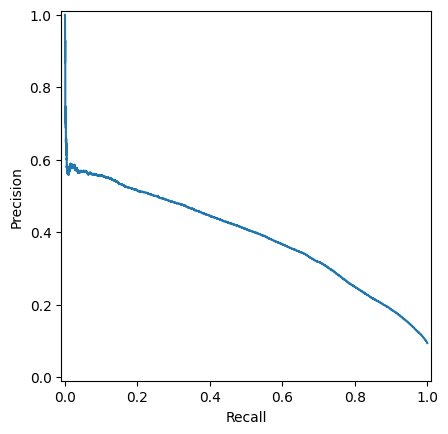

In [116]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# # precision_recall_curve(y_train_oof.get(), oof_pred)
# # y_train_oof

# p_r, r_r, _ = precision_recall_curve(y_train_oof.get(), oof_pred)
# disp = PrecisionRecallDisplay(precision=p_r, recall=r_r)
# disp.plot()
# plt.show()
# del disp

In [50]:
def f1_cust(input_true, input_pred):
  """Report the F1 score using inputs that might be mixed type.

    Args:
        input_true (np.ndarray or cp.ndarray): Array of true y values.
        input_parent (np.ndarray or cp.ndarray): Array of predicted y values.

    Returns:
        float: F1 score.
    """
  output_true = input_true.copy()
  output_pred = input_pred.copy()
  if not isinstance(output_true, np.ndarray):
    output_true = output_true.get()
  if not isinstance(output_pred, np.ndarray):
    output_pred = output_pred.get()

  # output_f1 = f1_score(output_true, output_pred)
  output_f1 = f1_score(output_true, output_pred)
  return output_f1

In [134]:
# Start w no smoothing
best_window_size = 1
# Start w default threshold
threshold = 0.5

y_bin = (oof_pred >= threshold).astype(np.int32)
# y_bin = cp.array(y_bin)
best_f1 = f1_cust(y_train_oof, y_bin)

best_threshold = threshold
thresholds = np.linspace(0.01, 0.99, 100)

# Keep track of tuning results
wt_tune_results = cudf.DataFrame(columns=['window', 'threshold', 'F1'])
# wt_tune_results = cudf.DataFrame(columns=['window', 'threshold', 'F1', 'Pre', 'Rec'])
# wt_p_r = cudf.DataFrame(columns=['window', 'Pre', 'Rec'])

print(f"Baseline\t---------->\tW:1\tT:{best_threshold}\t\tF1:{best_f1:.4}")

# Test range of odd window sizes
for current_window in range(WINDOW_MIN, WINDOW_MAX+1, 2):
    # smoothed_preds = smooth_window(oof_pred, window_size=current_window)
    smoothed_preds = medfilt(oof_pred, kernel_size=current_window)
    # wt_p_r_single = cudf.Series({
    #     "window": current_window,
    #     'Pre': precision_score(y_train_oof.get(), smoothed_preds),
    #     'Rec': recall_score(y_train_oof.get(), smoothed_preds)
    # })
    # Test range of possible threshold
    for threshold in thresholds:
        y_bin = (smoothed_preds >= threshold).astype(np.int32)
        current_f1 = f1_cust(y_train_oof, y_bin)
        # current_pre = precision_score(y_train_oof.get(), y_bin, zero_division=1)
        # current_rec = recall_score(y_train_oof.get(), y_bin, zero_division=1)
        # Keep track of scores
        # wt_tune_result = cudf.Series({"window": current_window, "threshold": threshold, 'F1':current_f1})
        wt_tune_result = cudf.Series({
            "window": current_window,
            "threshold": threshold,
            'F1':current_f1
            # 'Pre': current_pre,
            # 'Rec': current_rec
            })
        wt_tune_results = cudf.concat([wt_tune_results, wt_tune_result.to_frame().T])
        # If the F1 score has improved, update the values
        if current_f1 > best_f1:
          best_f1 = current_f1
          best_window = current_window
          best_threshold = threshold
    print(f"Trying win={current_window}; \tCurr best->\tW:{best_window}\tT:{best_threshold:.4}\tF1:{best_f1:.4}")

# oof_pred_adj = smooth_window(oof_pred, window_size=best_window)
oof_pred_adj = medfilt(oof_pred, kernel_size=best_window)
oof_pred_adj = (oof_pred_adj >= best_threshold).astype(int)

f1_rez = f1_cust(y_train_oof, oof_pred_adj)
print(f"Best parameters\t---------->\tW:{best_window}\tT:{best_threshold:.4f}\tF1:{f1_rez:.4}")

Baseline	---------->	W:1	T:0.5		F1:0.4353
Trying win=1; 	Curr best->	W:1	T:0.3763	F1:0.4561
Trying win=3; 	Curr best->	W:3	T:0.3763	F1:0.4563


KeyboardInterrupt: 

### Remove marginal gains

Remembering Occam's Razor... marginal gains in F1 can result in over-fitting (such as applying large smoothing windows for an F1 gain of, for instance, 0.0003).

In [ ]:
best_window_original = best_window
best_threshold_original = best_threshold

In [137]:
wt_mg = wt_tune_results.copy()

# Selecting the values where the F1 is within 99% of the best F1
print("Original F1:\t", best_f1)
f1_cutoff = 0.99 * best_f1
print("F1 99% / marginal-gains cutoff:\t", f1_cutoff)

print((len(wt_mg)/len(wt_tune_results)) * 100, "% of tested combinations are w/in 99% of the best F1")
# print(len(wt_mg))

print("-------------------------")

# Arrange in descending order: prioritize smaller windows
best_mg = wt_mg[wt_mg['F1']>=f1_cutoff].sort_values(['window','F1'],ascending=[True,False]).iloc[0]

if best_window != best_mg['window']:
  # print("-------------------------")
  print("New best window found.")
  print("Original:\t", best_window)
  print("Updated:\t", best_mg['window'])
  print("-------------------------")


if best_threshold != best_mg['threshold']:
  # print("-------------------------")
  print("New best threshold found.")
  print("Original:\t", best_threshold)
  print("Updated:\t", best_mg['threshold'])
  print("-------------------------")


# Update values
best_window = int(best_mg['window'])
best_threshold = float(best_mg['threshold'])

if best_window == 1:
  print("F1 did not significantly improve via windowed smoothing.\nNo windowing will be applied.")

Original F1:	 0.4566072741210082
F1 99% cutoff:	 0.45204120137979814
100.0 % of tested combinations are w/in 99% of the best F1
-------------------------
F1 did not significantly improve via windowed smoothing.
No windowing will be applied.


In [52]:
# cleanup
del current_f1, current_window, threshold, f1_rez, y_bin, best_f1, wt_tune_result, oof_pred_adj

In [53]:
play_chime()

## Applying to test set

In [57]:
final_model.fit(X_train, y_train)

y_test_conv = y_test.copy().to_cupy()
y_test_conv = y_test_conv.get()

In [106]:
final_pred_y = final_model.predict_proba(X_test)[:,1]
final_pred_y_base = (final_pred_y >= 0.5).astype(np.int32)
print("Base model (0.5 threshold, no smoothing)")

print(
    f"F1:\t{f1_score(y_test_conv, final_pred_y_base):.4f}",
    f"Acc:\t{accuracy_score(y_test_conv, final_pred_y_base):.4f}",
    f"Pre:\t{precision_score(y_test_conv, final_pred_y_base):.4f}",
    f"Rec:\t{recall_score(y_test_conv, final_pred_y_base):.4f}",
    "-----------------------------------",
    sep="\n"
)


print("Windowed with", best_window)

# final_pred_y_win = smooth_window(final_pred_y, window_size=best_window)
final_pred_y_win = medfilt(final_pred_y, kernel_size=best_window)
final_pred_y_win = (final_pred_y_win >= 0.5).astype(np.int32)

print(
    f"F1:\t{f1_score(y_test_conv, final_pred_y_win):.4f}",
    f"Acc:\t{accuracy_score(y_test_conv, final_pred_y_win):.4f}",
    f"Pre:\t{precision_score(y_test_conv, final_pred_y_win):.4f}",
    f"Rec:\t{recall_score(y_test_conv, final_pred_y_win):.4f}",
    "-----------------------------------",
    sep="\n"
)


print(f"Windowed & optmized threshold of {best_threshold:.4f}")

# final_pred_y = (final_pred_y >= best_threshold).astype(np.int32)
# final_pred_y_opt = smooth_window(final_pred_y, window_size=best_window)
final_pred_y_opt = medfilt(final_pred_y, kernel_size=best_window)
final_pred_y_opt = (final_pred_y_opt >= best_threshold).astype(np.int32)

print(
    f"F1:\t{f1_score(y_test_conv, final_pred_y_opt):.4f}",
    f"Acc:\t{accuracy_score(y_test_conv, final_pred_y_opt):.4f}",
    f"Pre:\t{precision_score(y_test_conv, final_pred_y_opt):.4f}",
    f"Rec:\t{recall_score(y_test_conv, final_pred_y_opt):.4f}",
    "-----------------------------------",
    sep="\n"
)

Base model (0.5 threshold, no smoothing)
F1:	0.3852
Acc:	0.6479
Pre:	0.2605
Rec:	0.7392
-----------------------------------
Windowed with 1
F1:	0.3852
Acc:	0.6479
Pre:	0.2605
Rec:	0.7392
-----------------------------------
Windowed & optmized threshold of 0.3763
F1:	0.3415
Acc:	0.4961
Pre:	0.2121
Rec:	0.8755
-----------------------------------


In [109]:
# Predictions on final test set
# with and without the various best-corrections
pred_y_none, pred_y_w, pred_y_t, pred_y_wt = apply_model(X_test, final_model, best_window, best_threshold, "all")

print("Corrections\tF1\tAcc\tPre\tRec")

# Get scores accordingly
print(
    # "Corrections\tF1\tAcc\tPre\tRec",
    "--------------------------------------------------",
    "\nNone:\t\t", report_scores(y_test_conv, pred_y_none, 4),
    f"\nW {best_window}:\t\t", report_scores(y_test_conv, pred_y_w, 4),
    f"\nT {best_threshold:.4}:\t", report_scores(y_test_conv, pred_y_t, 4),
    f"\nW{best_window} & T{best_threshold:.4}:\t", report_scores(y_test_conv, pred_y_wt, 4)
)

pred_y_none, pred_y_w, pred_y_t, pred_y_wt = apply_model(X_test, final_model, best_window_original, best_threshold_original, "all")

# Get scores accordingly
print(
    # "Corrections\tF1\tAcc\tPre\tRec",
    "--------------------------------------------------",
    "If F1 marginal gain limitation were not implemented:",
    "\nNone:\t\t", report_scores(y_test_conv, pred_y_none, 4),
    f"\nW {best_window_original}:\t\t", report_scores(y_test_conv, pred_y_w, 4),
    f"\nT {best_threshold_original:.4}:\t", report_scores(y_test_conv, pred_y_t, 4),
    f"\nW{best_window_original} & T{best_threshold_original:.4}:\t", report_scores(y_test_conv, pred_y_wt, 4)
)

Corrections	F1	Acc	Pre	Rec 
-------------------------------------------------- 
None:		 (0.3852, 0.6479, 0.2605, 0.7392) 
W 1:		 (0.3852, 0.6479, 0.2605, 0.7392) 
T 0.3763:	 (0.3415, 0.4961, 0.2121, 0.8755) 
W1 & T0.3763:	 (0.3415, 0.4961, 0.2121, 0.8755)
Corrections	F1	Acc	Pre	Rec 
-------------------------------------------------- 
None:		 (0.3852, 0.6479, 0.2605, 0.7392) 
W 35:		 (0.3872, 0.6503, 0.2622, 0.7404) 
T 0.3367:	 (0.328, 0.447, 0.2003, 0.9046) 
W35 & T0.3367:	 (0.3279, 0.4446, 0.2001, 0.9077)


In [ ]:
# Cleanup
del pred_y_none, pred_y_w, pred_y_t, pred_y_wt

In [60]:
play_chime()

## Save results

In [74]:
if os.path.exists(model_path(FITTED_MODEL_NAME)) == False:
  print("Saving final model...")

  joblib.dump(final_model, model_path(FITTED_MODEL_NAME))

  # Local download
  from google.colab import files
  files.download(model_path(FITTED_MODEL_NAME))

Saving final model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
## Save to wd

# Tuning results
wt_tune_results.to_parquet(get_path('results/train_oof_wt_tuning.parquet', 'outputs'))

# Indeces of test dates
test_dates = y_test.index.to_frame()
test_dates.to_parquet(get_path('results/test_index.parquet', 'outputs'))

# y predictions
np.save(get_path('results/test_y_pred.npy', 'outputs'), final_pred_y_opt)
np.save(get_path('results/test_y_pred_proba.npy', 'outputs'), final_pred_y_opt)

# actual test vals
np.save(get_path('results/test_y_true.npy', 'outputs'), y_test_conv)
# np.save(get_path('results/X_test_true.npy', 'outputs'), X_test)

In [77]:
# Save locally
files.download(get_path('results/train_oof_wt_tuning.parquet', 'outputs'))
files.download(get_path('results/test_index.parquet', 'outputs'))

files.download(get_path('results/test_y_pred.npy', 'outputs'))
files.download(get_path('results/test_y_pred_proba.npy', 'outputs'))

files.download(get_path('results/test_y_true.npy', 'outputs'))
# files.download(get_path('results/X_test_true.npy', 'outputs'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## (draft code)

### Feature importance

In [ ]:
feature_importances = final_model.feature_importances_
# map scores to feature names
# feature_importances
feature_names = X_train.columns.tolist()

feature_importance_df = pd.DataFrame({
    'feat': feature_names,
    'importance': feature_importances
})

# sort importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# print(feature_importance_df)
feature_importance_df

# most important features
# print(feature_importance_df.head(25))

In [ ]:
threshold_importance = 0.95
# calculate most important 90 percent of the importance
feature_importance_df['cumulative_imp'] = feature_importance_df['importance'].cumsum()
features_percent = feature_importance_df[feature_importance_df['cumulative_imp'] <= threshold_importance].shape[0] + 1
features_percent

In [ ]:
# Most important features:
print(round(threshold_importance*100), "% (most important features):", features_percent)
feature_importance_df.head(features_percent)

In [ ]:
# feature_importance_df.tail(1)
# Least important features:
print("Remaining", round((1-threshold_importance)*100), "% (least important features):", len(feature_names)-features_percent)
feature_importance_df.tail(len(feature_names)-features_percent)

In [ ]:
# Features with 0 importance:
print("Features with 0 importance:", len(feature_importance_df[feature_importance_df['importance']==0]))

feature_importance_df[feature_importance_df['importance']==0]

Feature importance by type

In [ ]:
mapping_dict = {
    'soil': '_deep|_shallow',
    'runoff':'ro',
    'rain':'rain',
    'calibration':'_cal'
}

for col_name, pattern in mapping_dict.items():
    feature_importance_df[col_name] = feature_importance_df['feat'].str.contains(pattern, case=False, regex=True)

feature_importance_df

In [ ]:
feature_importance_df['most'] = (feature_importance_df['cumulative_imp'] <= threshold_importance)
feature_importance_df['zero'] = (feature_importance_df['importance'] == 0)

cat_cols = list(mapping_dict.keys())

table_feature_cat_importance = pd.DataFrame({
    'Total features': feature_importance_df[cat_cols].sum(),
    'Above threshold': feature_importance_df[feature_importance_df['most']][cat_cols].sum(),
    'Below threshold': feature_importance_df[~feature_importance_df['most']][cat_cols].sum(),
    'Zero importance': feature_importance_df[feature_importance_df['zero']][cat_cols].sum()
}).fillna(0).astype(int)

del cat_cols, mapping_dict

table_feature_cat_importance.index.name = 'Category'

table_feature_cat_importance